In [1]:
# Install torch_geometric
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import torch
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from torch_geometric.data import Data

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import logging
from tqdm.notebook import tqdm  # Use notebook-specific tqdm for single-line updates
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the NetCDF file
nc_file1 = "/content/drive/MyDrive/ERA5_datasets/data_accum.nc"
nc_file2 = "/content/drive/MyDrive/ERA5_datasets/data_instant.nc"
ds1 = xr.open_dataset(nc_file1)
ds2 = xr.open_dataset(nc_file2)

ds = xr.merge([ds1, ds2], compat='override')
# Print dataset details
print(ds)

# Select variables
variables = ['tp', 't2m', 'd2m', 'u10', 'v10', 'msl', 'tcwv', 'cape', 'slhf', 'sshf']
data_arrays = [ds[var].values for var in variables]

# Stack variables into tensor [time, lat, lon, channels]
data = np.stack(data_arrays, axis=-1)  # Shape: [hours, lat, lon, 10]

# Normalize using StandardScaler (fit on train only)
hours = ds.valid_time.values
total_hours = len(hours)
train_end = int(0.8 * total_hours)
val_end = train_end + int(0.1 * total_hours)
scaler = StandardScaler()
train_data_reshaped = data[:train_end].reshape(-1, data.shape[-1])
scaler.fit(train_data_reshaped)
# Normalize in-place to save memory
data = scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)

# Store tp for labels
tp = ds['tp'].values

# Define dataset class
class ERA5Dataset(Dataset):
    def __init__(self, data, tp, indices, input_window=12, target_window=6, threshold=0.001):
        self.data = data
        self.tp = tp
        self.indices = indices
        self.input_window = input_window
        self.target_window = target_window
        self.threshold = threshold
        self.grid_size = (data.shape[1], data.shape[2])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        t = self.indices[idx]
        input_data = self.data[t:t+self.input_window]
        future_tp = self.tp[t+self.input_window:t+self.input_window+self.target_window]
        rain_label = (future_tp.sum(axis=0) > self.threshold).astype(np.int64)
        if not np.all(np.isin(rain_label, [0, 1])):
            print(f"Warning: Non-binary labels detected at index {idx}: {np.unique(rain_label)}")
            rain_label = np.clip(rain_label, 0, 1)
        return (torch.tensor(input_data, dtype=torch.float32),
                torch.tensor(rain_label, dtype=torch.long))

# Create indices for each split
input_window = 12
target_window = 6
train_indices = list(range(0, train_end - input_window - target_window + 1))
val_indices = list(range(train_end, val_end - input_window - target_window + 1))
test_indices = list(range(val_end, total_hours - input_window - target_window + 1))

# Initialize datasets
train_dataset = ERA5Dataset(data, tp, train_indices, input_window, target_window)
val_dataset = ERA5Dataset(data, tp, val_indices, input_window, target_window)
test_dataset = ERA5Dataset(data, tp, test_indices, input_window, target_window)

# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Compute rain percentage (sample-based to save memory)
rain_count = 0
total_nodes = 0
for idx in train_indices[:100]:
    future_tp = tp[idx+input_window:idx+input_window+target_window]
    rain_label = (future_tp.sum(axis=0) > 0.001).astype(int)
    rain_count += rain_label.sum()
    total_nodes += rain_label.size
rain_percentage = (rain_count / total_nodes) * 100 if total_nodes > 0 else 0
print(f"Approximate percentage of rain in training dataset: {rain_percentage:.2f}%")

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2160, latitude: 105, longitude: 237)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 17kB 2025-01-01 ... 2025-03-31T23...
  * latitude    (latitude) float64 840B 50.0 49.75 49.5 ... 24.5 24.25 24.0
  * longitude   (longitude) float64 2kB -125.0 -124.8 -124.5 ... -66.25 -66.0
    expver      (valid_time) <U4 35kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 215MB ...
    slhf        (valid_time, latitude, longitude) float32 215MB ...
    sshf        (valid_time, latitude, longitude) float32 215MB ...
    u10         (valid_time, latitude, longitude) float32 215MB ...
    v10         (valid_time, latitude, longitude) float32 215MB ...
    d2m         (valid_time, latitude, longitude) float32 215MB ...
    t2m         (valid_time, latitude, longitude) float32 215MB ...
    msl         (valid_time, latitude, longitude) float32 215MB ...
    tcwv        (valid_time,

In [4]:
# Updated CNNRainPredictor with third Conv3d layer
class CNNRainPredictor(nn.Module):
    def __init__(self, input_channels, hidden_dim, output_dim, grid_size):
        super(CNNRainPredictor, self).__init__()
        self.grid_size = grid_size
        self.conv1 = nn.Conv3d(input_channels, hidden_dim, kernel_size=(3, 3, 3), padding=1)
        self.conv2 = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=(3, 3, 3), padding=1)
        self.conv3 = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=(3, 3, 3), padding=1)  # New layer
        self.fc = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
        self.dropout = nn.Dropout(0.4)
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.upsample = nn.Upsample(size=grid_size, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)  # (batch_size, T, H, W, C) -> (batch_size, C, T, H, W)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.mean(dim=2)
        x = self.fc(x)
        x = self.upsample(x)
        return x

input_channels = 10
hidden_dim = 128
output_dim = 2
grid_size = (data.shape[1], data.shape[2])
model = CNNRainPredictor(input_channels, hidden_dim, output_dim, grid_size).to(device)


In [5]:

# Define loss functions and training utilities
def soft_f1_loss(y_true, y_pred, epsilon=1e-6):
    y_true = y_true.float()
    y_pred = torch.softmax(y_pred, dim=1)[:, 1, :, :]
    tp = torch.sum(y_true * y_pred)
    fp = torch.sum((1 - y_true) * y_pred)
    fn = torch.sum(y_true * (1 - y_pred))
    soft_precision = tp / (tp + fp + epsilon)
    soft_recall = tp / (tp + fn + epsilon)
    soft_f1 = 2 * (soft_precision * soft_recall) / (soft_precision + soft_recall + epsilon)
    return 1 - soft_f1

def focal_loss(y_pred, y_true, gamma=2.0, alpha=None):
    ce_loss = F.cross_entropy(y_pred, y_true, weight=alpha, reduction='none')
    p_t = torch.exp(-ce_loss)
    focal_loss = (1 - p_t) ** gamma * ce_loss
    return focal_loss.mean()

criterion_ce = nn.CrossEntropyLoss()
logging.basicConfig(filename='training_log.log', level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()
train_losses = []
train_accuracies = []
val_f1_scores = []
test_f1_scores = []

# Modified training cell with threshold grid search, fixed class weight, and optimal threshold for test
def train(model, train_loader, optimizer, device, class_weights, alpha=0.5, accum_steps=4):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()
    # Tqdm progress bar for training batches
    for i, (data, target) in enumerate(tqdm(train_loader, desc="Training Batches", leave=False)):
        data, target = data.to(device), target.to(device)
        out = model(data)
        if out.shape[2:] != target.shape[1:]:
            raise ValueError(f"Output spatial shape {out.shape[2:]} doesn't match target {target.shape[1:]}")
        ce_loss = criterion_ce(out, target)
        f1_loss = soft_f1_loss(target, out)
        focal = focal_loss(out, target, alpha=class_weights.to(device))
        loss = alpha * ce_loss + (1 - alpha) * f1_loss + focal
        loss = loss / accum_steps
        loss.backward()
        if (i + 1) % accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        total_loss += loss.item() * accum_steps
        preds = out.argmax(dim=1)
        correct += (preds == target).sum().item()
        total += target.numel()
    if len(train_loader) % accum_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, loader, device, threshold=0.77, dataset_name="Test"):
    model.eval()
    all_probs = []
    all_labels = []
    total_loss = 0
    total_samples = 0
    expected_samples = len(loader.dataset)

    with torch.no_grad():
        for data, target in tqdm(loader, desc=f"{dataset_name} Batches", leave=False):
            data, target = data.to(device), target.to(device)
            out = model(data)
            loss = criterion_ce(out, target)
            total_loss += loss.item() * data.size(0)

            # Extract probabilities for rain class
            probs = torch.softmax(out, dim=1)[:, 1, :, :]  # Shape: [batch_size, lat, lon]
            all_probs.append(probs.cpu().numpy())
            all_labels.append(target.cpu().numpy())
            total_samples += data.size(0)

    # Verify total samples
    if total_samples != expected_samples:
        print(f"Warning: Processed {total_samples} samples, expected {expected_samples}")

    # Concatenate across batches
    all_probs = np.concatenate(all_probs, axis=0)  # Shape: [num_samples, lat, lon]
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: [num_samples, lat, lon]

    # Check shape consistency
    if all_probs.shape != all_labels.shape:
        raise ValueError(f"Shape mismatch: all_probs {all_probs.shape}, all_labels {all_labels.shape}")

    avg_loss = total_loss / total_samples if total_samples > 0 else float('inf')

    # Compute predictions with explicit thresholding
    preds = (all_probs >= threshold).astype(np.int64)
    # Verify preds shape
    if preds.shape != all_labels.shape:
        raise ValueError(f"Preds shape {preds.shape} does not match all_labels shape {all_labels.shape}")

    # Compute metrics
    f1 = f1_score(all_labels.flatten(), preds.flatten(), average='binary')
    accuracy = accuracy_score(all_labels.flatten(), preds.flatten())
    precision = precision_score(all_labels.flatten(), preds.flatten())
    recall = recall_score(all_labels.flatten(), preds.flatten())
    pred_rain = np.sum(preds)
    true_rain = np.sum(all_labels)

    print(f"{dataset_name} - Threshold: {threshold:.2f}, Loss: {avg_loss:.4f}, F1: {f1:.4f}, "
          f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"{dataset_name} - Predicted Rain Nodes: {pred_rain}, True Rain Nodes: {true_rain}")

    return f1, accuracy, precision, recall, avg_loss, all_probs, all_labels

In [6]:
torch.cuda.empty_cache()

# Training with fixed class weight and threshold
class_weight = [1.0, 8.0]
fixed_threshold = 0.77
num_epochs = 20
best_val_f1 = 0.0

print(f"Starting Training with Class Weight: {class_weight} and Fixed Threshold: {fixed_threshold:.2f}")
model = CNNRainPredictor(input_channels, hidden_dim, output_dim, grid_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
class_weights = torch.tensor(class_weight, dtype=torch.float32).to(device)
patience = 6
patience_counter = 0

for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
    train_loss, train_acc = train(model, train_loader, optimizer, device, class_weights, alpha=0.5, accum_steps=4)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_f1, val_acc, val_prec, val_rec, val_loss, _, _ = evaluate(model, val_loader, device,
                                                                 threshold=fixed_threshold, dataset_name="Validation")
    val_f1_scores.append(val_f1)
    test_f1, test_acc, test_prec, test_rec, test_loss, _, _ = evaluate(model, test_loader, device,
                                                                      threshold=fixed_threshold, dataset_name="Test")
    test_f1_scores.append(test_f1)
    log_msg = (f'Class Weight: {class_weight}, Threshold: {fixed_threshold:.2f}, Epoch {epoch:02d}, '
               f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}')
    logger.info(log_msg)
    print(log_msg)
    scheduler.step(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_CNN_model.pth')
        patience_counter = 0
        print(f"New best model saved with Val F1: {val_f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print(f"\nFinal Evaluation of Best Model with Fixed Threshold: {fixed_threshold:.2f}")
model.load_state_dict(torch.load('/content/drive/MyDrive/best_CNN_model.pth'))
test_f1, test_acc, test_prec, test_rec, test_loss, all_probs, all_labels = evaluate(
    model, test_loader, device, threshold=fixed_threshold, dataset_name="Test")

Starting Training with Class Weight: [1.0, 8.0] and Fixed Threshold: 0.77


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.2207, F1: 0.5739, Accuracy: 0.9203, Precision: 0.7801, Recall: 0.4539
Validation - Predicted Rain Nodes: 340587, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.3201, F1: 0.5764, Accuracy: 0.8945, Precision: 0.6157, Recall: 0.5417
Test - Predicted Rain Nodes: 577199, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 01, Train Loss: 7.3594, Train Acc: 0.7947, Val F1: 0.5739, Test F1: 0.5764
New best model saved with Val F1: 0.5739


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1882, F1: 0.6570, Accuracy: 0.9332, Precision: 0.8355, Recall: 0.5414
Validation - Predicted Rain Nodes: 379308, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2684, F1: 0.6465, Accuracy: 0.9141, Precision: 0.7107, Recall: 0.5929
Test - Predicted Rain Nodes: 547306, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 02, Train Loss: 0.7993, Train Acc: 0.8990, Val F1: 0.6570, Test F1: 0.6465
New best model saved with Val F1: 0.6570


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1868, F1: 0.7341, Accuracy: 0.9425, Precision: 0.8100, Recall: 0.6712
Validation - Predicted Rain Nodes: 485010, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2405, F1: 0.7124, Accuracy: 0.9305, Precision: 0.7884, Recall: 0.6497
Test - Predicted Rain Nodes: 540581, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 03, Train Loss: 0.7058, Train Acc: 0.9170, Val F1: 0.7341, Test F1: 0.7124
New best model saved with Val F1: 0.7341


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1845, F1: 0.6839, Accuracy: 0.9396, Precision: 0.8972, Recall: 0.5526
Validation - Predicted Rain Nodes: 360535, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2165, F1: 0.6660, Accuracy: 0.9287, Precision: 0.8772, Recall: 0.5367
Test - Predicted Rain Nodes: 401403, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 04, Train Loss: 0.6107, Train Acc: 0.9235, Val F1: 0.6839, Test F1: 0.6660


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1649, F1: 0.7432, Accuracy: 0.9456, Precision: 0.8407, Recall: 0.6660
Validation - Predicted Rain Nodes: 463703, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2183, F1: 0.7310, Accuracy: 0.9348, Precision: 0.8062, Recall: 0.6686
Test - Predicted Rain Nodes: 544062, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 05, Train Loss: 0.5562, Train Acc: 0.9270, Val F1: 0.7432, Test F1: 0.7310
New best model saved with Val F1: 0.7432


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1598, F1: 0.7407, Accuracy: 0.9460, Precision: 0.8560, Recall: 0.6528
Validation - Predicted Rain Nodes: 446431, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.1900, F1: 0.7264, Accuracy: 0.9356, Precision: 0.8306, Recall: 0.6454
Test - Predicted Rain Nodes: 509800, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 06, Train Loss: 0.5227, Train Acc: 0.9275, Val F1: 0.7407, Test F1: 0.7264


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1770, F1: 0.7389, Accuracy: 0.9456, Precision: 0.8540, Recall: 0.6512
Validation - Predicted Rain Nodes: 446383, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2219, F1: 0.7177, Accuracy: 0.9343, Precision: 0.8328, Recall: 0.6306
Test - Predicted Rain Nodes: 496783, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 07, Train Loss: 0.4862, Train Acc: 0.9316, Val F1: 0.7389, Test F1: 0.7177


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1768, F1: 0.7602, Accuracy: 0.9485, Precision: 0.8453, Recall: 0.6908
Validation - Predicted Rain Nodes: 478348, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2151, F1: 0.7407, Accuracy: 0.9378, Precision: 0.8270, Recall: 0.6707
Test - Predicted Rain Nodes: 532093, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 08, Train Loss: 0.4744, Train Acc: 0.9324, Val F1: 0.7602, Test F1: 0.7407
New best model saved with Val F1: 0.7602


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.2058, F1: 0.7782, Accuracy: 0.9498, Precision: 0.8150, Recall: 0.7445
Validation - Predicted Rain Nodes: 534694, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2394, F1: 0.7499, Accuracy: 0.9384, Precision: 0.8115, Recall: 0.6970
Test - Predicted Rain Nodes: 563468, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 09, Train Loss: 0.4606, Train Acc: 0.9342, Val F1: 0.7782, Test F1: 0.7499
New best model saved with Val F1: 0.7782


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1668, F1: 0.7262, Accuracy: 0.9445, Precision: 0.8703, Recall: 0.6230
Validation - Predicted Rain Nodes: 419059, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2246, F1: 0.7291, Accuracy: 0.9363, Precision: 0.8342, Recall: 0.6475
Test - Predicted Rain Nodes: 509235, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 10, Train Loss: 0.4549, Train Acc: 0.9349, Val F1: 0.7262, Test F1: 0.7291


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.2228, F1: 0.7826, Accuracy: 0.9482, Precision: 0.7760, Recall: 0.7892
Validation - Predicted Rain Nodes: 595295, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2900, F1: 0.7590, Accuracy: 0.9343, Precision: 0.7383, Recall: 0.7810
Test - Predicted Rain Nodes: 694048, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 11, Train Loss: 0.4653, Train Acc: 0.9321, Val F1: 0.7826, Test F1: 0.7590
New best model saved with Val F1: 0.7826


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1726, F1: 0.7789, Accuracy: 0.9505, Precision: 0.8247, Recall: 0.7379
Validation - Predicted Rain Nodes: 523716, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2092, F1: 0.7578, Accuracy: 0.9390, Precision: 0.7989, Recall: 0.7208
Test - Predicted Rain Nodes: 591891, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 12, Train Loss: 0.4539, Train Acc: 0.9345, Val F1: 0.7789, Test F1: 0.7578


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1676, F1: 0.7771, Accuracy: 0.9494, Precision: 0.8111, Recall: 0.7459
Validation - Predicted Rain Nodes: 538304, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2033, F1: 0.7583, Accuracy: 0.9388, Precision: 0.7954, Recall: 0.7244
Test - Predicted Rain Nodes: 597496, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 13, Train Loss: 0.4464, Train Acc: 0.9352, Val F1: 0.7771, Test F1: 0.7583


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1967, F1: 0.7745, Accuracy: 0.9495, Precision: 0.8203, Recall: 0.7336
Validation - Predicted Rain Nodes: 523500, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2348, F1: 0.7538, Accuracy: 0.9378, Precision: 0.7926, Recall: 0.7185
Test - Predicted Rain Nodes: 594700, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 14, Train Loss: 0.4393, Train Acc: 0.9361, Val F1: 0.7745, Test F1: 0.7538


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1676, F1: 0.7723, Accuracy: 0.9501, Precision: 0.8385, Recall: 0.7157
Validation - Predicted Rain Nodes: 499604, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2163, F1: 0.7515, Accuracy: 0.9395, Precision: 0.8239, Recall: 0.6908
Test - Predicted Rain Nodes: 550121, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 15, Train Loss: 0.4391, Train Acc: 0.9359, Val F1: 0.7723, Test F1: 0.7515


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.2060, F1: 0.7857, Accuracy: 0.9500, Precision: 0.7966, Recall: 0.7752
Validation - Predicted Rain Nodes: 569620, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2517, F1: 0.7654, Accuracy: 0.9389, Precision: 0.7790, Recall: 0.7522
Test - Predicted Rain Nodes: 633491, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 16, Train Loss: 0.4239, Train Acc: 0.9385, Val F1: 0.7857, Test F1: 0.7654
New best model saved with Val F1: 0.7857


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1686, F1: 0.7700, Accuracy: 0.9505, Precision: 0.8537, Recall: 0.7013
Validation - Predicted Rain Nodes: 480825, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2040, F1: 0.7459, Accuracy: 0.9390, Precision: 0.8321, Recall: 0.6759
Test - Predicted Rain Nodes: 532898, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 17, Train Loss: 0.4201, Train Acc: 0.9388, Val F1: 0.7700, Test F1: 0.7459


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.2036, F1: 0.7912, Accuracy: 0.9509, Precision: 0.7957, Recall: 0.7867
Validation - Predicted Rain Nodes: 578751, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2470, F1: 0.7679, Accuracy: 0.9388, Precision: 0.7712, Recall: 0.7646
Test - Predicted Rain Nodes: 650422, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 18, Train Loss: 0.4206, Train Acc: 0.9388, Val F1: 0.7912, Test F1: 0.7679
New best model saved with Val F1: 0.7912


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1806, F1: 0.7858, Accuracy: 0.9514, Precision: 0.8194, Recall: 0.7549
Validation - Predicted Rain Nodes: 539258, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2139, F1: 0.7611, Accuracy: 0.9404, Precision: 0.8110, Recall: 0.7171
Test - Predicted Rain Nodes: 580082, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 19, Train Loss: 0.4158, Train Acc: 0.9396, Val F1: 0.7858, Test F1: 0.7611


Training Batches:   0%|          | 0/214 [00:00<?, ?it/s]

Validation Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Validation - Threshold: 0.77, Loss: 0.1941, F1: 0.7894, Accuracy: 0.9515, Precision: 0.8107, Recall: 0.7691
Validation - Predicted Rain Nodes: 555353, True Rain Nodes: 585350


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2297, F1: 0.7624, Accuracy: 0.9399, Precision: 0.7997, Recall: 0.7284
Test - Predicted Rain Nodes: 597551, True Rain Nodes: 656033
Class Weight: [1.0, 8.0], Threshold: 0.77, Epoch 20, Train Loss: 0.4184, Train Acc: 0.9391, Val F1: 0.7894, Test F1: 0.7624

Final Evaluation of Best Model with Fixed Threshold: 0.77


Test Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Test - Threshold: 0.77, Loss: 0.2470, F1: 0.7679, Accuracy: 0.9388, Precision: 0.7712, Recall: 0.7646
Test - Predicted Rain Nodes: 650422, True Rain Nodes: 656033


In [7]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 106.8 MB/s eta 0:00:00


In [8]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches

Confusion Matrix Inputs - all_labels shape: (199, 105, 237), all_probs shape: (199, 105, 237)
Preds shape after thresholding: (199, 105, 237)
Flattened shapes - labels: (4952115,), preds: (4952115,)


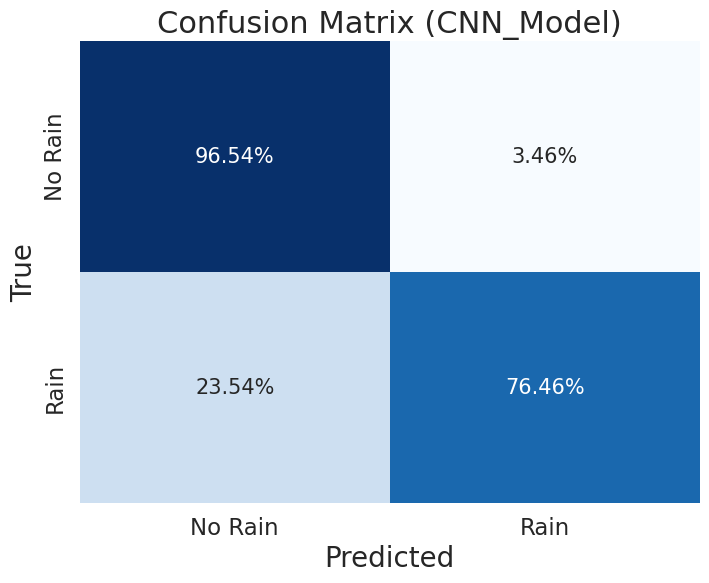

In [9]:
# Verify shapes before confusion matrix
print(f"Confusion Matrix Inputs - all_labels shape: {all_labels.shape}, all_probs shape: {all_probs.shape}")
if all_labels.shape != all_probs.shape:
    raise ValueError(f"Shape mismatch: all_labels {all_labels.shape}, all_probs {all_probs.shape}")

# Compute predictions with explicit thresholding
preds = (all_probs >= fixed_threshold).astype(np.int64)
print(f"Preds shape after thresholding: {preds.shape}")

# Verify flattened shapes
flat_labels = all_labels.flatten()
flat_preds = preds.flatten()
print(f"Flattened shapes - labels: {flat_labels.shape}, preds: {flat_preds.shape}")
if flat_labels.shape != flat_preds.shape:
    raise ValueError(f"Flattened shape mismatch: labels {flat_labels.shape}, preds {flat_preds.shape}")

cm = confusion_matrix(flat_labels, flat_preds)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100  # Normalize by row
sns.set(font_scale=1.5)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'],
            annot_kws={'size': 15})
for text in plt.gca().texts:
    text.set_text(f"{float(text.get_text()):.2f}%")
plt.title('Confusion Matrix (CNN_Model)', fontsize=22)
plt.xlabel('Predicted', fontsize = 20)
plt.ylabel('True', fontsize = 20)
plt.savefig('/content/drive/MyDrive/CNN_confusion_matrix_row_normalized.png')
plt.show()

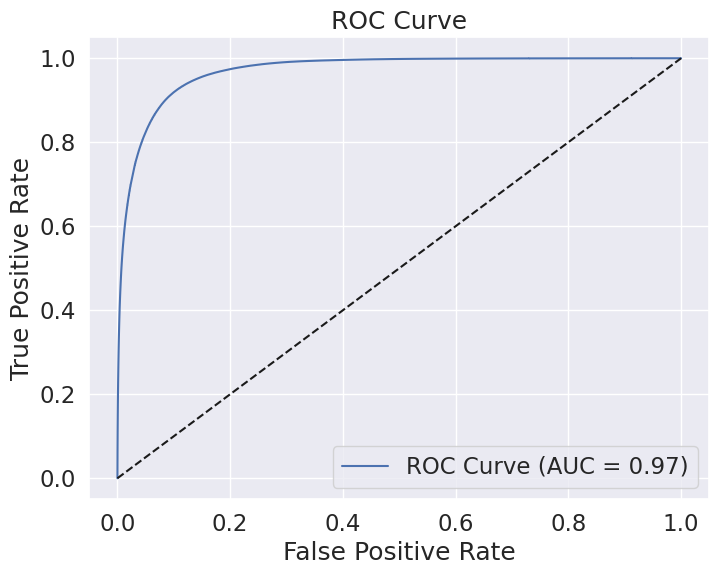

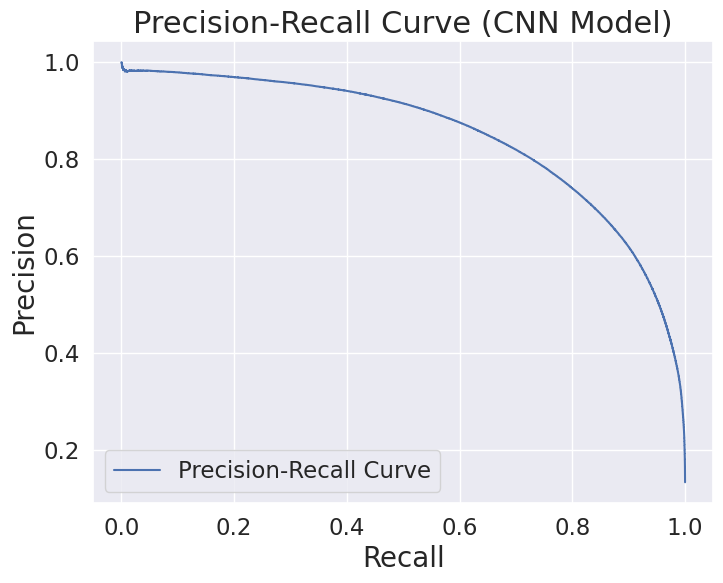

In [10]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(flat_labels, all_probs.flatten())
roc_auc = roc_auc_score(flat_labels, all_probs.flatten())
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/content/drive/MyDrive/CNN_roc_curve.png')
plt.show()

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(flat_labels, all_probs.flatten())
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall Curve (CNN Model)', fontsize=22)
plt.legend(loc='lower left')
plt.savefig('/content/drive/MyDrive/CNN_precision_recall_curve.png')
plt.show()

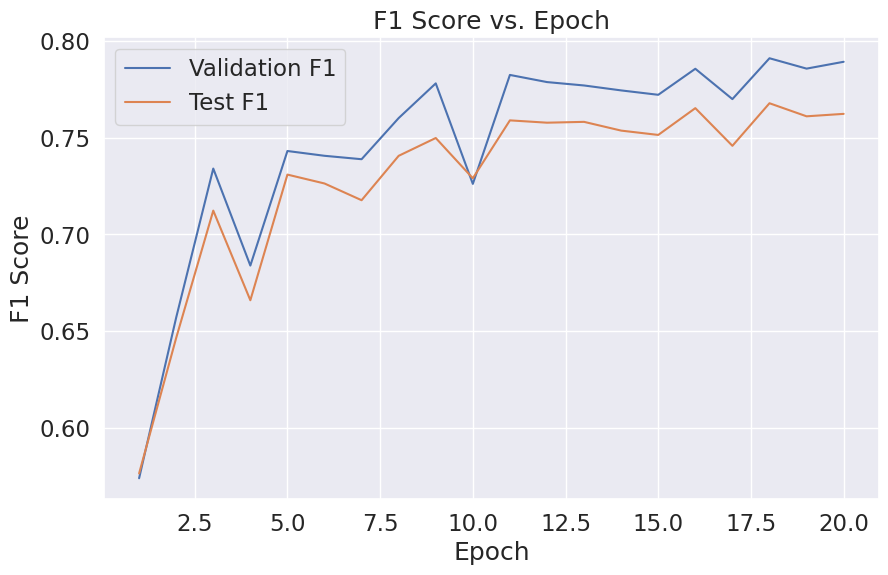

In [11]:
# Plot F1 score vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1')
plt.plot(range(1, len(test_f1_scores) + 1), test_f1_scores, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epoch')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/CNN_f1_score_vs_epoch.png')
plt.show()

Sample 0: True rain points: 2239, 
Sample 0: Predicted rain points: 1651, 


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

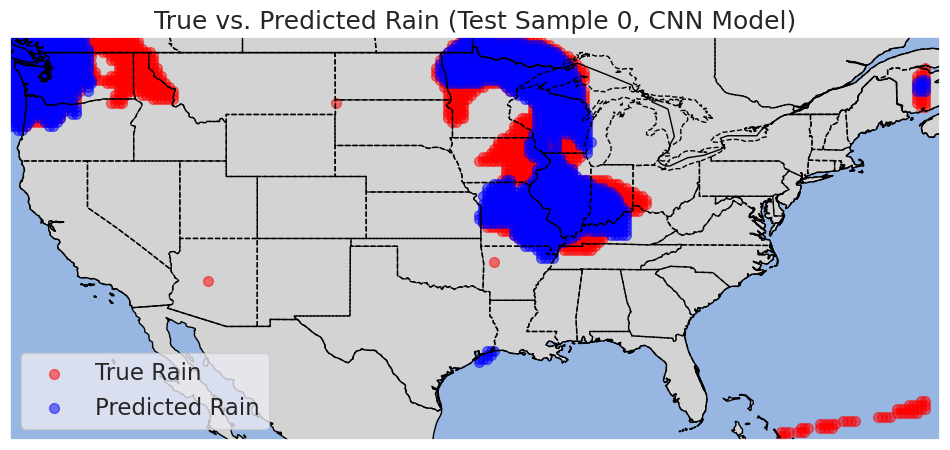

Sample 50: True rain points: 1574, 
Sample 50: Predicted rain points: 1117, 


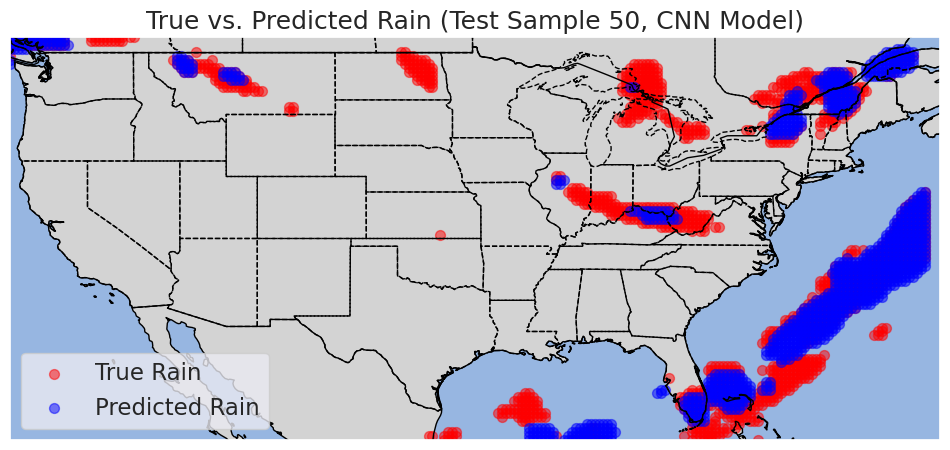

Sample 100: True rain points: 2538, 
Sample 100: Predicted rain points: 1886, 


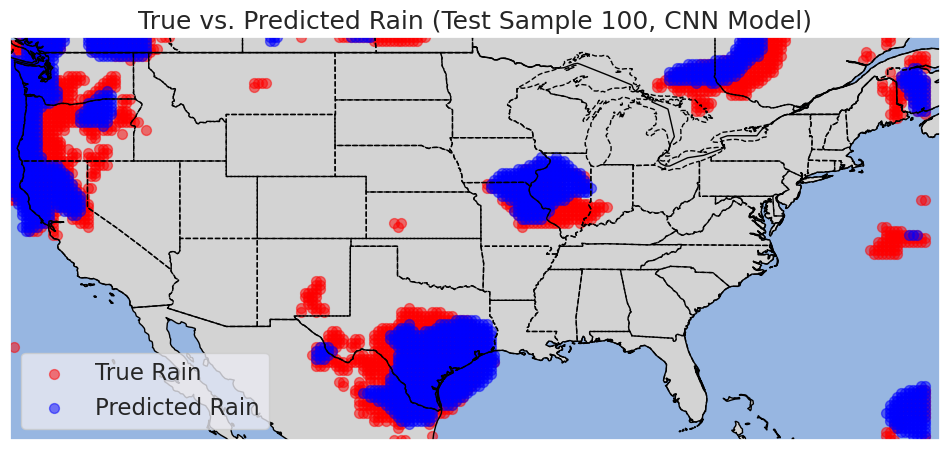

In [12]:
# Spatial Map Comparison for Selected Test Samples
# Define latitude and longitude
lat = ds.latitude.values  # Shape: (105,)
lon = ds.longitude.values  # Shape: (237,)

# Debug coordinate shapes and ranges
#print(f"Longitude shape: {lon.shape}, range: {lon.min():.2f} to {lon.max():.2f}")
#print(f"Latitude shape: {lat.shape}, range: {lat.min():.2f} to {lat.max():.2f}")

test_sample_indices = [0, 50, 100]  # Valid indices for len(test_dataset) = 199

for test_sample_idx in test_sample_indices:
    if test_sample_idx >= len(test_dataset):
        print(f"Skipping index {test_sample_idx}: Out of bounds (max {len(test_dataset)-1})")
        continue
    input_data, true_labels = test_dataset[test_sample_idx]  # Unpack input and labels
    input_data = input_data.unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        model.eval()
        out = model(input_data)
        probs = torch.softmax(out, dim=1)[:, 1, :, :]  # Shape: [batch_size, N_lat, N_lon]
        preds = (probs >= fixed_threshold).float()
    preds = preds.cpu().numpy().squeeze()  # Shape: [105, 237]
    true = true_labels.cpu().numpy()  # Shape: [105, 237]

    # Debug shapes
    #print(f"Sample {test_sample_idx}: true shape: {true.shape}, preds shape: {preds.shape}")

    # Get indices where rain occurs
    true_rain_idx = np.where(true == 1)
    pred_rain_idx = np.where(preds == 1)

    # Debug index ranges
    #print(f"Sample {test_sample_idx}: True rain row indices max: {true_rain_idx[0].max() if len(true_rain_idx[0]) > 0 else 'None'}")
    #print(f"Sample {test_sample_idx}: True rain col indices max: {true_rain_idx[1].max() if len(true_rain_idx[1]) > 0 else 'None'}")

    # Map indices to coordinates
    true_lat = lat[true_rain_idx[0]]  # Rows (latitude, size 105)
    true_lon = lon[true_rain_idx[1]]  # Columns (longitude, size 237)
    pred_lat = lat[pred_rain_idx[0]]
    pred_lon = lon[pred_rain_idx[1]]

    # Debug number of points and coordinate ranges
    print(f"Sample {test_sample_idx}: True rain points: {len(true_lon)}, ")
    #      f"lon range: {true_lon.min():.2f} to {true_lon.max():.2f}, "
    #      f"lat range: {true_lat.min():.2f} to {true_lat.max():.2f}")
    print(f"Sample {test_sample_idx}: Predicted rain points: {len(pred_lon)}, ")
    #      f"lon range: {pred_lon.min():.2f} to {pred_lon.max():.2f}, "
    #      f"lat range: {pred_lat.min():.2f} to {pred_lat.max():.2f}")
    #
    # Spatial Map
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle='--')

    # Scatter plots
    ax.scatter(true_lon, true_lat, c='red', s=50, alpha=0.5, label='True Rain', transform=ccrs.PlateCarree())
    ax.scatter(pred_lon, pred_lat, c='blue', s=50, alpha=0.5, label='Predicted Rain', transform=ccrs.PlateCarree())

    plt.title(f'True vs. Predicted Rain (Test Sample {test_sample_idx}, CNN Model)')
    plt.legend()
    plt.savefig(f'/content/drive/MyDrive/CNN_spatial_prediction_{test_sample_idx}.png')
    plt.show()